# Función para crear la malla de un cilindro

Suponga que quiero crear un cilindoro de altura $h$ y radio $R$. 

    [imagen cilindro altura y radio]

Vamos a definir un nivel de subdivión $k$, que nos indicará que tan fina será la malla. Una malla más fina tiene más elementos para definir la misma superficie.

    [imagen cilindro malla fina y gruesa]

Consideraremos un primer anillo de este cilindro y vamos a definir que cada anillo tiene una cantidad de nodos definida por:

 $$N_t= 2^{2+k}$$
 
 De esta forma tenemos que cada punto del anillo está separado por un ángulo (en radianes) que llamaremos $dt$:
 
 $$d_t=\frac{2\pi}{N_t}$$


In [1]:
from numpy import *
R=4
h=10
K=3
Nt=2**(2+K)
dt=2*pi/Nt
Nt, dt

(32, 0.19634954084936207)

En general buscamos que la malla generada tenga alta isotropía, por esto los tiangulos generados deben ser los más cercano a un triángulo equilátero. El número de anillos determina la altura de cada triángulo.

El lado de cada triángulo está dado por:
$$R.sin(d_t)$$

Para generar un triángulo equilátero buscamos una altura similar a:
$$ h_{eqi}=[R\sin(d_t)] . \sin (\pi/3)$$

Debido a que la altura $h$ se ha fijado al inicial el problema, podemos obtener el número de anillos dividiendo esa altura total por la altura ideal del triańgulo equilátero. Hay que considerar que ese valor deve ser entero, por lo que se redondea al entero superior, y además se debe agregar un "techo" por lo que se suma 1, entonces tenemos el número de anillos $N_z$:
$$N_z= ceil  \left( \frac{h}{h_{eqi}} +1 \right)$$


De este modo obtenemos la altura final de cada tríangulo $d_z$, es decir la separación de cada anillo.
$$d_z =\frac{h}{N_z -1} $$


In [2]:
h_eq=(sin(dt)*R*sin(pi/3))
Nz = int(ceil(h/h_eq + 1))
dz = h/(Nz-1);

Nz,dz, h_eq

(16, 0.6666666666666666, 0.6758126995938145)

Podemos ver que la diferncia entre el valor de altura ideal para cáda triángulo $h_eq$ y el que se usa finalmente $d_z$ es muy pequeña.

## Obetniendo cada punto de cada anillo

Ahora para con estos datos debemos obtener todos los puntos de la malla que representará la superficie del cilindro

In [3]:
L0 = -0.5 * h                                  # para que el cilindro quede centrado

X = zeros([Nt*Nz,3])

ptId = 0
for i in range(0, Nz):                         # para cada anillo
    for j in range(0, Nt):                     # para cada punto del anillo
        theta = dt * (j + 0.5*mod(i,2))
        X[ptId,0] = R * cos(theta)
        X[ptId,1] = R * sin(theta)
        X[ptId,2] = (i*dz) + L0 
        ptId = ptId+1

## Graficando los puntos obtenidos

<IPython.core.display.Javascript object>


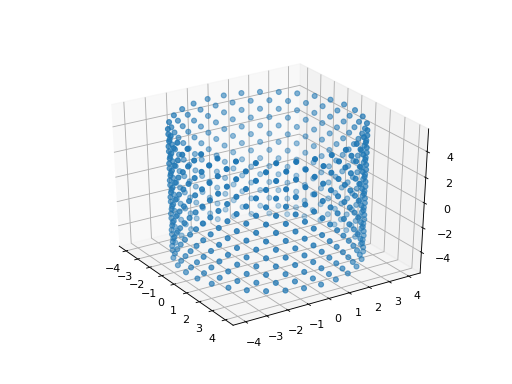

In [16]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2], 'gray')

## Limpiando el error numérico
Si analizamos los datos en muchos casos encontramos valores que en lugar de ser exactos tienen un error muy pequeño producido por la precisión de máquina.

Por ejemplo veamos aquellos valores en $x$ que tienen un valor muy cercano a $0$, en este caso seleccionaré los que son menores a $1\times 10^{-6}$

In [6]:
X[abs(X[:,0])<1e-6,0]

array([ 2.44929360e-16, -7.34788079e-16,  2.44929360e-16, -7.34788079e-16,
        2.44929360e-16, -7.34788079e-16,  2.44929360e-16, -7.34788079e-16,
        2.44929360e-16, -7.34788079e-16,  2.44929360e-16, -7.34788079e-16,
        2.44929360e-16, -7.34788079e-16,  2.44929360e-16, -7.34788079e-16])

Es conveniente que estos valores sean exactamente igual a 0 para futuras operaciones, por lo que podemos convertirlos de esta manera

In [7]:
X[abs(X[:,0])<1e-6,0]=0

Si volvemos a consultar los valores de $x$ menores a $1\times 10 ^{-6}$, veremos que ahora todos son igual a $0$:

In [8]:
X[abs(X[:,0])<1e-6,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Este principio lo aplicaremos para todos los valoers de $x,y,z$ cercanos a $0,R, h$

In [9]:
X[abs(X[:,0])<1e-6,0]=0            # valores de x cercanos a 0
X[abs(X[:,1])<1e-6,1]=0            # valores de y cercanos a 0 
X[abs(X[:,2])<1e-6,2]=0            # valores de z cercanos a 0

X[abs(X[:,0]-R) <1e-6,0]=R         # valores de x cercanos a R
X[abs(X[:,0]+R) <1e-6,0]=-R        # valores de x cercanos a -R

X[abs(X[:,1]-R) <1e-6,1]=R         # valores de y cercanos a R
X[abs(X[:,1]+R) <1e-6,1]=-R        # valores de y cercanos a -R

X[abs(X[:,2]-h*0.5)<1e-6,2]=h/2    # valores de z cercanos a h/2
X[abs(X[:,2]+h*0.5)<1e-6,2]=-h/2   # valores de z cercanos a -h/2

## Creando elementos
Los siguiente es crear la conectividad que define cada polígono, en este caso son todos triángulos. Estos los llamaremos elementos que es la forma típica de nombrarlos en elementos finitos

El número total de elementos, en este caso está dado por:

$$N_{el}=2. N_t.(N_z -1)$$

Consideremos un primer anillo, donde por cada nodo tenemos dos triángulos $(2 N_t)$. Esto se repite por cada anillo menos en el último q puede considerarse como una "tapa" por eso se multiplica por $(N_z-1)$

Cada elemento se define por los nodos que lo conforman. En este caso por ser una malla compuesta solo por triángulos, cada elemento está definido por tres nodos.



In [10]:
nElem = 2*(Nz-1)*Nt;
T= zeros([nElem,3])                          # matriz para de conectividad cada fila tiene los tres nodos de un elemento
nElem

960

  [gráfico con índices de nodos para filas pares e impares]

In [11]:
e=0;                                         # índice del elemento
for k in range(0, (Nz-1)):                   # para cada anillo excepto el último
    if (mod(k,2)!=0):                        # para los k que son impares   es decir, número de anillo impar
        for i in range(0,Nt-1):                # para cada nodo del anillo
            ii= (k)*Nt+i                     # el índice del nodo en la lista global de nodos
            T[e,:]=[ii, ii+1, Nt+ii+1]       # construye el elemento
            e+=1                             # paso al siguiente elemento
            
            T[e,:] = [ii, Nt+ii+1, Nt+ii]
            e = e+1
            
        T[e,:]= [(k+1)*Nt-1, k*Nt, (k+1)*Nt]
        e+=1                                 # paso al siguinte elemento
        
        T[e,:]=[(k+1)*Nt-1,  (k+1)*Nt,  (k+2)*Nt-1]
        e+=1
        
    else:                                    # para los anillos de índice par
        for i in range(0, Nt-1):             # para cada nodo del anillo
            ii = (k)*Nt + i                
            T[e,:]=[ii,ii+1, Nt+ii]          
            e+=1                             
                                             
            T[e,:]=[ii+1, Nt+ii+1, Nt+ii]    
            e+=1               
            
        T[e,:]=[(k+1)*Nt-1, (k)*Nt, (k+2)*Nt-1]
        e+=1                                 
        
        T[e,:] =[k*Nt,(k+2)*Nt-1, (k+1)*Nt]
        e = e+1

In [636]:
X[0],X[1],X[Nt],

(array([ 4.,  0., -5.]),
 array([ 3.92314112,  0.78036129, -5.        ]),
 array([ 3.98073891,  0.39206856, -4.33333333]))

In [13]:
b = zeros((960,4))
b[:,1:4]=T
b[:,0]=3*ones([960], dtype=int)
faces=hstack(b)


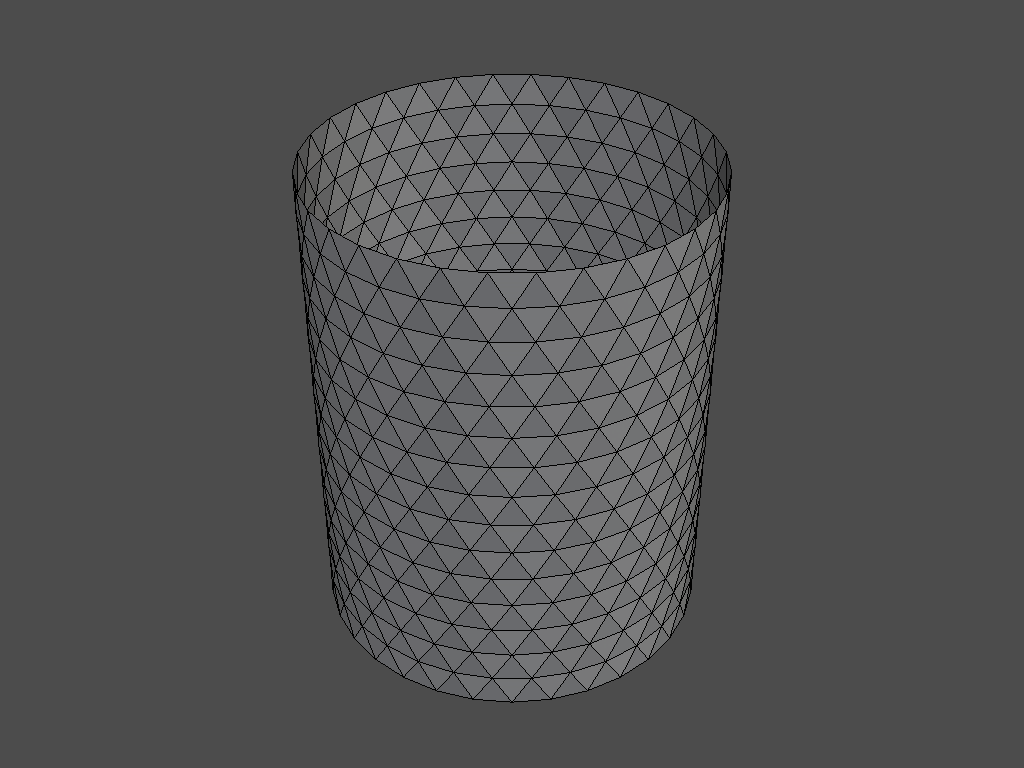

In [14]:
import pyvista as pv
from itkwidgets import view

surf = pv.PolyData(X,faces)
surf.plot(show_edges=True)

surf.save("cilindro.vtk")

***

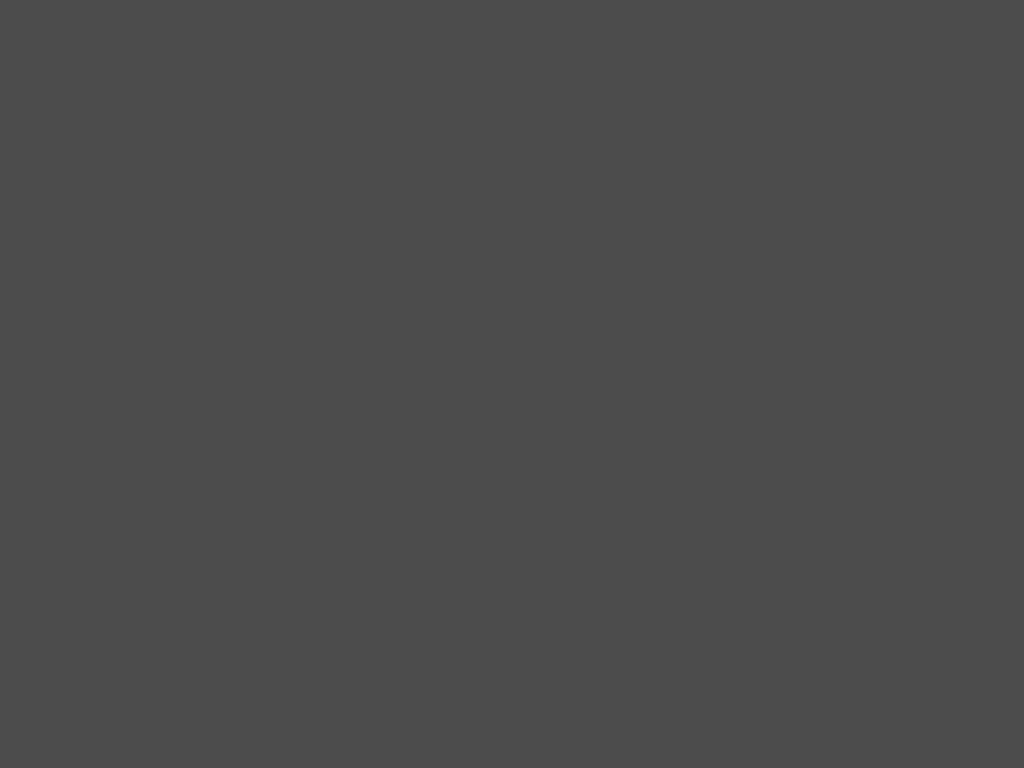

In [15]:
e=0;                                           # índice del elemento
for k in range(0, (Nz-1)):                     # para cada anillo excepto el último
    if (mod(k,2)==0):                          # para los k que son pares   es decir, número de anillo impar
        for i in range(0,Nt-1):                # para cada nodo del anillo
            ii= (k)*Nt+i
            T[e,:] = [ii , ii+Nt , ii+2*Nt-1]
            e+=1                             
            T[e,:] = [ii , ii+1 , ii+Nt]       # construye el elemento
            e = e+1
            
        T[e,:]= [(k+1)*Nt-1, k*Nt, (k+2)*Nt-1]
        e+=1                                 
        
        T[e,:]= [(k+1)*Nt-1, (k+2)*Nt-1, (k+2)*Nt-2]
        e+=1
        
    else:                                      # para los anillos de índice impar
        for i in range(0, Nt-1):               # para cada nodo del anillo    
            ii= (k)*Nt+i                                
            T[e,:]=[ii, ii+Nt+1,ii+Nt]    
            e+=1                 
            
            T[e,:]=[ii , ii+1 , ii+Nt+1]          
            e+=1                             
          
            
        T[e,:]=[(k+1)*Nt-1, (k+1)*Nt, (k+2)*Nt]
        e+=1                                 
        
        T[e,:] =[(k+1)*Nt-1, k*Nt, (k+1)*Nt]
        e = e+1
        

b = zeros((960,4))
b[:,1:4]=T
b[:,0]=3*ones([960], dtype=int)
faces=hstack(b)


import pyvista as pv
from itkwidgets import view

surf = pv.PolyData(X,faces)
surf.plot(show_edges=True)
